In [1]:
import pandas as pd
import numpy as np

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import matplotlib.pyplot as plt
from xgboost import plot_importance
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.model_selection import StratifiedKFold
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb

import utils

plt.style.use('ggplot')
%matplotlib inline
from sklearn.metrics import log_loss

In [2]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';', na_values='None')

train = utils.clean_data(train, more_clean=True)
test = utils.clean_data(test, more_clean=True)

train = utils.new_features(train)
test = utils.new_features(test)

X_train = train.drop([ 'cardio'], axis=1)
y_train = train['cardio'].values.ravel()
X_test = test.drop([], axis=1)

data = pd.concat((train.drop('cardio', axis=1), test), axis=0)
dic = data.groupby('age_group_orig')['age'].mean().to_dict()
X_train['age_dif'] = X_train[['age_group_orig', 'age']].apply(lambda x: x['age'] - dic[x['age_group_orig']], axis=1)
X_test['age_dif'] = X_test[['age_group_orig', 'age']].apply(lambda x: x['age'] - dic[x['age_group_orig']], axis=1)

dic2 = data.groupby('age_group_orig')['age'].min().to_dict()
dic3 = data.groupby('age_group_orig')['age'].max().to_dict()
X_train['age_dif2'] = X_train[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)
X_test['age_dif2']  =  X_test[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)

dic3 = data.groupby('age_group_orig')['age'].std().to_dict()
X_train['age_dif3'] = X_train[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)
X_test['age_dif3']  =  X_test[['age_group_orig', 'age']].apply(lambda x: (x['age'] - dic2[x['age_group_orig']]) / dic3[x['age_group_orig']], axis=1)


In [3]:
start_columns = [
'gender',
'ap_hi',
'ap_lo',
'cholesterol',
'active_fair',
'smoke_restored',
'alco_restored',
'height_mul_log_cholesterol',
'height_mul_log_gluc',
'BMI',
'age_group',
'cholesterol_div_log_gluc',
'gluc_mul_log_age',
'age_dif2',
'ap_lo_mul_log_ap_hi',
'age_group_div_height',
'age_group_mul_log_MAP',
'cholesterol_div_ap_hi',
'ap_hi_mul_log_gluc',
'BMI_div_ap_hi',
'BMI_div_log_age',
# 'gluc',
'gluc_mul_height',
    
# gender
# ap_hi
# ap_lo
# cholesterol
# active_fair
# smoke_restored
# alco_restored
# height_mul_log_cholesterol
# height_mul_log_gluc
# BMI
# age_group
# cholesterol_div_log_gluc
# gluc_mul_log_age
# ap_hi_mul_weight
# age_dif
# ap_lo_mul_log_ap_hi
# age_group_div_height
# age_group_mul_log_MAP
]

additional = [
    'age_dif','age_dif3',
 'ap_hi_group_3', 'ap_hi_group_4',
'ap_lo_group_3', 'ap_lo_group_4',
'gluc',
    'ap_hi_group_2',
 'MAP_div_BMI',
 'cholesterol_div_weight',
 'gluc_div_age_group',
 'MAP_div_ap_lo',
 'age_group_div_cholesterol',
 'cholesterol_div_age_group',
 'ap_hi_div_cholesterol',
 'age_group_mul_log_MAP',
 'age_div_age_group',
 'ap_hi_div_weight',
 'MAP_div_gluc',
 'gluc_div_log_ap_lo',
 'cholesterol_div_ap_hi',
 'ap_lo_div_log_cholesterol',
 'ap_lo_mul_log_height',
 'age_mul_log_gluc',
 'age_group_div_height',
 'ap_hi_div_ap_lo',
 'age_group_div_log_age',
 'age_group_div_age',
 'ap_lo_mul_log_ap_hi',
 'ap_hi_div_log_age',
 'cholesterol_mul_log_ap_hi',
 'ap_hi_div_log_ap_hi',
 'ap_hi_log',
 'ap_hi_mul_ap_hi',
 'ap_hi_mul_log_ap_hi',
 'age_group_mul_log_ap_lo',
 'BMI_div_MAP',
 'height_mul_log_ap_hi',
 'cholesterol_div_log_ap_hi',
 'age_group_mul_weight',
 'weight_mul_age_group',
 'gluc_div_log_ap_hi',
 'weight_mul_log_cholesterol',
 'cholesterol_mul_log_age',
 'ap_dif_2',
 'height_div_log_gluc',
 'gluc_div_height',
 'cholesterol_div_age',
 'gluc_mul_height',
 'height_mul_gluc',
 'gluc_mul_log_height',
 'age_group_mul_gluc',
 'gluc_mul_age_group',
 'ap_hi_div_log_gluc',
 'gluc_div_log_MAP',
 'MAP_mul_age_group',
 'age_group_MAPX',
 'age_group_mul_MAP',
 'ap_hi_div_log_height',
 'weight_mul_log_age_group',
 'age_group_div_weight',
 'MAP_div_cholesterol',
 'age_group_mul_log_BMI',
 'weight_div_age_group',
 'MAP_mul_ap_lo',
 'ap_lo_mul_MAP',
 'MAP_div_weight',
 'age_mul_gluc',
 'gluc_mul_age',
 'age_group_div_log_weight',
 'ap_hi_div_gluc',
 'gluc_mul_log_cholesterol',
 'ap_lo_div_MAP',
 'height_div_BMI',
 'height_div_log_age',
 'cholesterol_div_log_age_group',
 'ap_hi_div_age_group',
 'height_div_gluc',
 'age_group_div_log_MAP',
 'cholesterol_div_log_age',
 'gluc_div_ap_hi',
 'cholesterol_mul_gluc',
 'gluc_mul_cholesterol',
 'age_div_cholesterol',
 'cholesterol_div_MAP',
 'cholesterol_mul_log_gluc',
 'age_group_mul_log_height',
 'ap_hi_mul_log_gluc',
 'BMI_div_ap_hi',
 'MAP_mul_cholesterol',
 'cholesterol_mul_MAP',
 'gluc_div_cholesterol',
 'age_group_div_log_cholesterol',
 'cholesterol_div_log_MAP',
 'age_mul_cholesterol',
 'cholesterol_mul_age',
 'age_group_mul_log_weight',
 'BMI_group',
 'height_group',
 'height_div_age_group',
 'weight_div_log_height',
 'ap_hi_mul_log_age_group',
 'weight_div_ap_lo',
 'ap_dif',
 'gluc_mul_log_age_group',
 'gluc_div_log_age_group',
 'BMI_div_cholesterol',
 'BMI_3',
 'age_group_mul_log_cholesterol',
 'BMI_div_log_age',
 'weight_group',
 'cholesterol_div_log_ap_lo',
 'BMI_mul_ap_hi',
 'ap_hi_mul_BMI',
 'MAP_div_log_age_group'
]

# cols = list(start_columns)
# for c in additional:
#     if c not in cols:
#         cols.append(c)

# X_train = X_train[cols]
start=[]
for sc in start_columns:
    start.append(X_train.columns.get_loc(sc))
start
# X_train['age_dif']

[2,
 5,
 6,
 7,
 14,
 15,
 16,
 147,
 151,
 18,
 28,
 312,
 324,
 443,
 260,
 93,
 119,
 302,
 231,
 382,
 365,
 331]

In [4]:
# X_train[start_columns+additional]['age_dif']

In [4]:
len(X_train.columns)

445

0.00349092		age_group
0.00817874		cholesterol
0.00917614		gender
0.00987433		alco_restored
0.0102733		gluc_mul_height
0.0137642		smoke_restored
0.0159585		ap_lo
0.0248354		ap_hi_mul_log_gluc
0.0257331		cholesterol_div_ap_hi
0.0261321		cholesterol_div_log_gluc
0.0316178		active_fair
0.0442849		ap_lo_mul_log_ap_hi
0.0549571		ap_hi
0.0571514		height_mul_log_gluc
0.0718133		age_group_div_height
0.0720128		age_group_mul_log_MAP
0.0764014		BMI_div_ap_hi
0.085777		height_mul_log_cholesterol
0.0872731		BMI_div_log_age
0.0885697		gluc_mul_log_age
0.0892679		BMI
0.093457		age_dif2


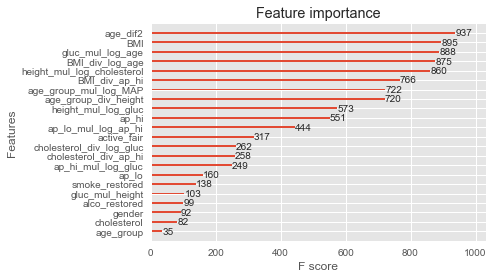

In [6]:
params = {
 'colsample_bytree': 0.875,
     'gamma': 0.05,
     'learning_rate': 0.02,
     'max_depth': 5,
     'min_child_weight': 5,
     'n_estimators': 369,

     'reg_alpha': 0,
     'reg_lambda': 10,
     'subsample': 0.7,
    
    'n_jobs': -1,
    'random_state': 1111,
    'silent': True,
}
clf = xgb.XGBClassifier(**params)
clf.fit(X_train[start_columns], y_train)
for a, b in sorted(zip(clf.feature_importances_, X_train[start_columns].columns)):
    print(a,b, sep='\t\t')
plot_importance(clf)
plt.show()

In [11]:
kf = StratifiedKFold(random_state=11111, n_splits=7, shuffle=True)
sfs = SFS(clf, 
           k_features=42, 
           forward=True, 
           floating=True, 
           verbose=2,
           scoring='neg_log_loss',
#            scoring='accuracy',
           n_jobs=1,
           cv=kf)

In [12]:
sfs = sfs.fit(X_train.values, y_train, start_features=start)


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [19]:
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
23,-0.537211,0.0022774,"[-0.5415948853, -0.535612477078, -0.5368277708...","(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.00306633,0.00102211


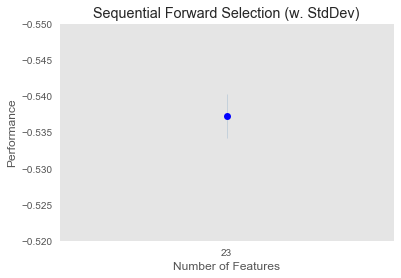

In [20]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([-0.52, -0.55])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [21]:
sfs.get_metric_dict()

{23: {'avg_score': -0.53721068477880407,
  'ci_bound': 0.0022774008647900479,
  'cv_scores': array([-0.54159489, -0.53561248, -0.53682777, -0.53738504, -0.5315209 ,
         -0.54015891, -0.54056423, -0.5334383 , -0.53913898, -0.53586536]),
  'feature_idx': (0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   21,
   22,
   32,
   68),
  'std_dev': 0.0030663271224524451,
  'std_err': 0.0010221090408174816}}

In [22]:
for i in (0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   21,
   22,
   32,
   68):
    print(X_train.columns[i])

gender
ap_hi
ap_lo
cholesterol
active_fair
smoke_restored
alco_restored
height_mul_log_cholesterol
height_mul_log_gluc
BMI
age_group
cholesterol_div_log_gluc
gluc_mul_log_age
age_dif2
ap_lo_mul_log_ap_hi
age_group_div_height
age_group_mul_log_MAP
cholesterol_div_ap_hi
ap_hi_mul_log_gluc
BMI_div_ap_hi
BMI_div_log_age
gluc
gluc_mul_height


In [ ]:
X_train['lo_14s'].value_counts()

In [9]:
start_columns+[]

['gender',
 'height',
 'weight',
 'ap_hi',
 'ap_lo',
 'cholesterol',
 'height_div_ap_lo',
 'active_fair',
 'smoke_restored',
 'alco_restored',
 'height_mul_log_cholesterol',
 'height_mul_log_gluc',
 'BMI',
 'age_group',
 'cholesterol_div_log_gluc',
 'gluc_mul_log_age',
 'ap_hi_mul_weight']

In [5]:
params = {
    'colsample_bytree': 0.875,
     'gamma': 0.05,
     'learning_rate': 0.02,
     'max_depth': 5,
     'min_child_weight': 5,
     'n_estimators': 369,

     'reg_alpha': 0,
     'reg_lambda': 10,
     'subsample': 0.7,
    
    'n_jobs': -1,
    'random_state': 1111,
    'silent': True,
}

def get_score(column=None):
#     print(X_train[start_columns + ([column] if column else [])])
    score1, score2 = utils.execute_model(xgb.XGBClassifier(**params),
              X_train[start_columns + ([column] if column else [])],
              y_train,
#               X_test,
#               model_name="model1",
#               n_splits=15,
              n_folds=7,
            verbose=0,
            seed=207
             )
    return score1

In [11]:
import gc

reference = get_score()
print('reference', reference)
gc.collect()
for c in X_train.columns:
    if c not in start_columns:
        score = get_score(c)
        gc.collect()
        if score < reference:
            print(score, c)   

reference 0.537331130912
0.537300866686 ap_hi_group_3
0.537319298181 ap_hi_group_2
0.537303688578 gluc_div_age_group
0.537229148293 MAP_div_ap_lo
0.537293372628 age_group_div_cholesterol
0.537289917524 age_div_age_group
0.53725391585 ap_hi_div_weight
0.537293152435 gluc_div_log_ap_lo
0.537288896483 ap_lo_div_log_cholesterol
0.537320193407 age_mul_log_gluc
0.537284541377 ap_hi_div_ap_lo
0.537291671349 age_group_div_log_age
0.537292232891 age_group_div_age
0.537323058382 ap_hi_div_log_ap_hi
0.537323058382 ap_hi_log
0.53732204441 ap_hi_mul_ap_hi
0.53732204441 ap_hi_mul_log_ap_hi
0.537295271067 height_mul_log_ap_hi
0.537283473633 cholesterol_div_log_ap_hi
0.537277779395 height_div_log_gluc
0.537311647028 gluc_div_height
0.537323842088 age_group_mul_gluc
0.537323842088 gluc_mul_age_group
0.537292995651 ap_hi_div_log_gluc
0.537302358189 age_group_div_log_weight
0.537293966684 ap_hi_div_gluc
0.53731600078 gluc_mul_log_cholesterol
0.537270762723 ap_lo_div_MAP
0.537301023157 height_div_gluc
0.5

In [10]:
import gc
gc.collect()

11176

In [44]:
print('done!')

done!


In [6]:
import gc

reference = get_score()
print('reference', reference)
gc.collect()
for c in X_train.columns:
    if (c not in start_columns) and (c not in additional):
        score = get_score(c)
        gc.collect()
        if score < reference:
            print(score, c)   

reference 0.537331130912
0.53731110166 age
0.537298226782 smoke
0.537306753884 alco
0.537279005386 active
0.537325771079 alco_fair
0.537241493761 BMI_1
0.537320034737 MAP
0.537310397437 MAP_2
0.537319039014 age_years
0.537311123226 age_log
0.537316356096 age_mul_age
0.537316268463 age_mul_log_age
0.537310834349 age_div_log_age
0.53731110166 age_mul_age_group
0.537311179264 age_mul_log_age_group
0.537270622857 age_div_log_height
0.537330718354 age_div_height
0.537290547981 age_mul_weight
0.53731085594 age_div_log_weight
0.537328129368 age_mul_log_ap_hi
0.537310292033 age_div_log_gluc
0.53729855418 age_div_gluc
0.537315527312 age_div_BMI
0.53731110166 age_group_mul_age
0.537311197634 age_group_mul_log_age
0.537325017011 age_group_mul_ap_hi
0.537314864734 age_group_div_ap_hi
0.537297235402 age_group_div_ap_lo
0.537255877533 age_group_div_log_gluc
0.537282646481 age_group_div_gluc
0.537291825603 age_group_div_log_BMI
0.53730952446 age_group_div_BMI
0.537316646562 height_mul_log_age
0.53731